### CS/ECE/ISyE 524 &mdash; Introduction to Optimization &mdash; Spring 2018 ###

# Optimal Skill-Based Worker Assignment

#### Noah Rhodes (nrhodes@wisc.edu), Alliot Nagle (acnagle@wisc.edu), and Liam Marshall (limarshall@wisc.edu)

*****

### Table of Contents

1. [Introduction](#1.-Introduction)
1. [Mathematical Model](#2.-Mathematical-model)
  1. [Model 1: Simple Assignment](#2.A-Model-1:-Simple-Assignment)
  1. [Model 2: Variety Assignment](#2.B-Model-2:-Variety-Assignment)
  1. [Model 3: Binary Task Bundles](#2.C-Model-3:-Binary-Task-Bundles)
1. [Solution](#3.-Solution)
  1. [Model 1: Simple Assignment](#3.A-Model-1:-Simple-Assignment)
  1. [Model 2: Variety Assignment](#3.B-Model-2:-Variety-Assignment)
  1. [Model 3: Binary Task Bundles](#3.C-Model-3:-Binary-Task-Bundles)
1. [Results and Discussion](#4.-Results-and-discussion)
  1. [Model Solving Speed](#4.A-Model-Solving-Speed)
    1. [Simple Assignment Speed](#4.A.a-Simple-Assignment-Speed)
    1. [Variety Assignment Speed](#4.A.b-Variety-Assignment-Speed)
    1. [Binary Task Bundles Speed](#4.A.c-Binary-Task-Bundles-Speed)
    1. [Binary Task Bundles vs. Variety Assignment Speed](#4.1.d-Binary-Task-Bundles-vs.-Variety-Assignment-Speed)
  1. [Data Interpretation](#4.B-Data-Interpretation)
1. [Conclusion](#5.-Conclusion)

## 1. Introduction ##

An important aspect of project management is assigning workers to tasks, and doing so in an efficient manner.
Several aspects can be considered such as decreasing worker boredom _[1]_, maximizing productivity, or increasing robustness to workers not showing up.

Our project is focusing on minimizing the time to complete a project, given a set of workers and tasks.
Our unique twist is to account for how repeating a task can lead to decreasing time required to complete it, which we call the worker's _learning model_.

The goal of the project is to find an optimal schedule for assigning workers with specific set of skills to a set of tasks.
Each task has a defined amount of work that needs to be done in order to complete a task, and the amount of time a worker spends on completing a task depends on his or her skill set.
In addition, when a worker completes a task, they become more skilled at performing that task, completing it more quickly in the future.
An optimal schedule could minimize the length of a project timeline by assigning workers to tasks that match the skills they have, or it might assign a low skill worker to a job several times to in order for them to learn the skill and be highly productive in the long run.  

The inspiration for this project comes from work with Engineers Without Borders.
As designs for a bridge, a microgrid, or a water system are finalized, a construction schedule must be planned.
Every household in the community contributes a person to the construction, which means access to a large amount of labor; however, these workers are not typically highly skilled in the type of required work.
However, at low skill levels, repeated work can lead to a rapidly increasing productivity **[cite?]**.
A tool to better estimate how worker productivity may change over the course of a project would dramatically help in the creation of feasible project timelines. 

In large projects, the number of tasks often significantly outnumbers the workers and we must decide how to assign our workers.
Do we have workers that specialize in a task and complete it quickly, or instead have workers who can generalize and complete a variety of tasks more slowly.  How do we assign our workers to a project timeline to optimize the completion time?

We develop a model to find an optimal schedule for worker assignment based on the amount of work each task requires and the skill level of each worker.
This model can be useful for a wide array of applications.
For example, developing a construction timeline and determining what combination of worker assignments will allow a project to be completed quickly.
An additional use may be to decide if it will be more productive to have a worker learn on the job or instead give a worker training where they stop producing work but may return with a higher skill level. 

We data for our model, using very broad assumptions/estimates.
Our goal is to prove that that our model can be viable for a variety of assignment problems, rather focus on a specific worker dataset.
We will create worker skill levels and learning speeds from random distributions restricted to a sensible range of values.

Depending on the variety of types of tasks in a project, the quantity of those tasks, the number of workers, and any initial skills the workers have, we can expect a different optimal assignment of tasks to workers.
This is leads to a question of whether workers should generalize or specialize in a skill, or how short-term optimal worker assignment compares to long-term optimal assignment.
Our project hopes to provide an answer to these questions and their dependency on initial conditions. 

----

[1]: Bhadury, J., and Z. Radovilsky. "Job rotation using the multi-period assignment model." _International Journal of Production Research_ 44.20 (2006): 4431-4444.

## 2. Mathematical model ##


Our problem is economic question of worker productivity and how it can be maximized by modeling how worker productivity changes over time.  We plan to model effects that increase productivity such as repeating a similar task or providing training, as well as effects that decrease productivity such as forgetting a skill over time.  

Our project is a blend of an assignment problem and a planning problem, where we assign workers to tasks in the planning problem, and the speed of completing a tasks in the planning problems depends on the worker productivity, which changed based on previous assignments.  The complexity of our project is the result of of this feedback between these two models, resulting in a considerable amount of logic constraints, a large solution space, and significant scaling challenges.  We hope to find methods of modeling this problem as a flow problem, as both subsets of this problem can be modeled in this way, in order to remove the integer constraints on our assignments and model this problem as Linear Program, rather than an Integer program.  We begin with small models incorporating small sections of our target model.  Our goal is to create a model that does the following:


>$
\begin{align*}
\min_{\text{worker assignment}}\quad & \textrm{Time to complete all tasks} \\
\text{subject to:}\quad & \text{Each task must be completed;}  \\ 
                        & \text{Each worker is assigned one task at a time;} \\
                        & \text{Worker productivity changes based on past assignments.} \\
\end{align*}
$

### 2.A Model 1: Simple Assignment ###

Our first model is an initial proof of concept that will allow us to see initial shortcomings of a more complex model.  In this model, we have only one type of task, all workers complete tasks in the same amount of time, and no worker-learning is modeled.  We attempt to create a very simple model under these conditions that will be easy to scale and add other model characteristics.

Based on our project goals, we realized we would need to evaluate discrete time points to decide when a worker is working on a given task, when they start the next task, and how working on a task now changes the speed of working on future tasks in later iterations of our model. Our initial model is below.

>$
\begin{align*}
\min_{x_{ijt},\,\lambda}\quad & \lambda \\
\text{s.t.}\quad & \sum\limits_{i=1}^N x_{ijt} \le 1 & \forall j \in \{1, \dots, W\}, \, t  \in \{1, \dots, T\} & & \text{(1)}\\ 
                 & \sum\limits_{j=1}^W \sum\limits_{t=1}^T x_{ijt} = 1 & \forall i \in \{1, \dots, N\} & & \text{(2)} \\
                 & \sum\limits_{j=1}^W \sum\limits_{t=1}^T x_{ijt}*t \leq \lambda & \forall i \in \{1, \dots, N\} & & \text{(3)} \\
\end{align*}
$

>Where
* $x_{ijt} \in \{0,1\}$ is 1 if worker $i$ is working on the $j$th task at time $t$
* $\lambda$ is the time the last task is completed
* $W$ is the number of workers
* $N$ is the number of tasks
* $T$ is an upper bound on the task completion time

>Notes on the constraints:
1. Each worker is limited to one task at a time
2. Each task is worked on exactly once
3. $\lambda$ is greater than or equal to largest completion time of any task


In this model, the solution is trivial: all tasks should be evenly divided among all workers because any task assigned to any worker is completed in the same amount of time.  This allows us to easily verify this initial model.  

### 2.B Model 2: Variety Assignment ###

Using the first model as a basis, we wanted to include non-unique worker skills and a variety of task types.  For example, in the Engineers Without Borders project, we may have some workers who are more skilled in laying concrete for water tanks and others who are more skilled in digging and laying pipes for the water lines.  How do we assign these workers optimally when the number of workers skilled in a task does not match the work that must be accomplished in that task? 

The next step is to incorporate a variety of types of tasks and workers who have a different completion time for each task.  This requires some additional logic constraints that massively increased the complexity of solving this model in comparison to [Model 1](#2.A-Model-1:-Simple-Assignment).  Instead of requiring the sum along the task dimension of $x_{ijk}$ to be equal to one to enforce the completion of each task,  we now have tasks that require an unknown amount of time to complete depending on the worker who is assigned.  Additionally the constraint for enforcing each worker to be assigned no more than one task simultaneously in complicated by the variety of tasks that may assigned from from any of the assignment groups.



> $
\begin{align*}
\min_{x_{ijkt},\,z_{ijkt},\,\lambda}\quad & \lambda \\
\text{s.t.}\quad & \sum\limits_{k=1}^{W}  \sum\limits_{t=1}^T z_{ijkt} \le 1 & \forall i \in \{1, \dots, N\}, \,j \in \{1, \dots, v\} & & \text(1) \\
                 & \sum\limits_{i=1}^N \sum\limits_{j=1}^V x_{ijkt} = 1  & \forall k \in \{1, \dots , W\} , \,t \in \{1, \dots, T\} & & \text{(2)}\\
                 & \sum\limits_{i=1}^N \sum\limits_{k=1}^W \sum\limits_{t=1}^T x_{ijkt} = n_j & \forall j \in \{1, \dots, V\} & & \text(3) \\
                 & \sum\limits_{t=1}^T x_{ijkt}*(t+w_{kj}) \le \lambda & \forall i \in \{1, \dots, N\}, \,j \in \{1, \dots, V\}, \,k \in \{1, \dots , W\} & & \text{(4)}\\
                 & z_{ijkl} >= x_{ijkt} & \forall i \in \{1, \dots, N\}, \,j \in \{1, \dots, V\}, \,k \in \{1, \dots , W\}, \,t \in \{1, \dots, T\}, \, l \in \{t, \dots ,w_{kj}\} & & \text{(5)}\\
\end{align*}
$

> Where
* $z_{ijkt} \in \{0, 1\}$ is $1$ if worker $i$ is working on the $k$th task of type $j$ at time $t$.
* $x_{ijkt} \in \{0, 1\}$ is $1$ if worker $i$ starts the $k$th task of type $j$ at time $t$.
* $\lambda$ is the time the last task is completed
* $w_{ij}$ is the speed with which worker $i$ completes task $j$.
* $n_i$ is the work quota for task type $i$.
* $W$ is an number of workers
* $N$ is the maximum quota in $n$
* $V$ is the number of task types
* $T$ is an upper bound on the number of timesteps considered in the model.  

> Notes on the constraints:
1. Each worker is limited to one task at a time
2. Each task is started exactly once
3. We must meet work quotas for each task type
4. $\lambda$ is greater than or equal to largest completion time of any task
5. Enforces the relation between starting a task and whether a worker is currently working on the task


As we developed this model, we realized it was similar to a quadratic assignment problem. A quadratic assignment problem follows this format: 

*Assign facilities to fixed locations. The facilities have known communication requirements and incurred costs depend on the distances between the facilities.* _[1]_

In our example, each worker is a "facility" and each task type is a "location".  We have "communication constraints" and costs each time a worker is assigned as task in each "location".  As a result, we have a quadratic assignment that that contains on the order of $W_{workers}*V_{task types}*N_{tasks}*T_{time steps}$. To apply a model to a useful scenario size, we would require  $\approx 10^5$ boolean variables, a problem size that requires far more computation time than is reasonable for this project.  Further analysis of the relative speeds of each model is shown in [Section 4.1](#4.1-Model-Solving-Speed).

Our original goal was to create a an amalgamation of an assignment problem with a planning problem, both Linear Programs, that could also be modeled as an LP, or at least solve on a similar timescale. 
In order to do this, we need to relax some requirements to our problem in order attempt to address our primary focus: how do worker skills change as over the course of a project as they are assigned a variety of tasks.

---

[1]: Lessard, UW ECE 524 (Spring 2018), Lecture 22:  http://www.laurentlessard.com/teaching/cs524/slides/22%20-%20more%20models,%20QAP%20and%20SOS.pdf.

### 2.C Model 3: Binary Task Bundles ###

In our third model, we relax the requirement of finding an ordering of the tasks each worker completes.  We assume that the learning process for each worker will depend on the number of times that task is completed and not on the temporal density of assignments. This allows us to stop modeling the discrete times when a worker is assigned at ask and only consider a boolean, 'is this task assigned to this worker'.  However, we will not have the option to enforce any ordering in which the tasks take place and so will not be able to set prerequisite task completions.  As a result, our problem not longer fully resembles a planning problem and is an assignment problem with non-linear cost.



>$
\begin{align*}
\min_{x \in \{0, 1\}^{W\times J\times T},\,\lambda \ge 0}\quad & \lambda \\
\text{s.t.}\quad & \sum_{t=1}^{T} \sum_{i=1}^{W} t\,x_{i,j,t} \ge q_j & \forall j \in \{1, \dots, J\} & & \text{(1)}\\
                 & \sum_{j=1}^{J} \sum_{t=1}^{T} B(j, t)\,x_{i,j,t} \le \lambda & \forall i \in \{1, \dots, W\} & & \text{(2)}\\
                 & \text{SOS1}\,\{ x_{i,j,t}\;\forall t \in {1, \dots, T} \} & \forall i \in \{1, \dots, W\},\,j \in \{1, \dots, J\} & & \text{(3)}\\
\end{align*}
$

>where
* $x_{i,j,t} \in \{0, 1\}$ is $1$ if worker $i$ is working on task $j$ at time $t$.
* $\lambda$ is the time the slowest worker takes to complete all their tasks.
* $W$ is the number of workers.
* $J$ is the number of tasks.
* $T$ is the maximum number of units of work per a (worker, job) combination considered in the problem.
* $q_j$ is the work unit quota for task $j$.
* $B(j, t)$ is the time required to perform job $j$ $t$ times; this might scale non-linearly with $t$ as a worker learns that job.

>Notes on the constraints:
1. We must meet work quotas $q$.
2. Lower-bound $\lambda$ by every worker's completion time; $\lambda$ is the time for the slowest worker to complete all tasks.
3. Only one binary time may be active per job + worker combination.

We are now able to model our problem as a min-cost flow problem. The Worker - Task connections are the number of times worker $i$ is assigned task type $j$.  These assignments are constrained to be integers, and the cost is the time the workers needs to complete that quantity of tasks.  Task - Quota connections aggregate the number of times each task type has been assigned.  The Quotas - Task End connections enforce the number of times each task must be completed.  This final connections forces a certain amount of assignments "flow" through the network, and we minimize the cost of this flow by distributing the task assignments between all workers. 

![](https://i.imgur.com/rmpeUqr.png)

Unfortunately, the objective is nonlinear once we model worker learning, meaning that we need boolean constraints on our worker assignments.  We no longer have a Quadratic Assignment problem and instead have a a mixed integer program.  It is not linear, but it should solve considerably faster than Model 2. 

## 3. Solution ##

Each of our models was created in Julia, along with a method of viewing the worker schedule for each model.  An analysis comparing the models follows in [4. Results and discussion](#4.-Results-and-discussion)

### 3.A Model 1: Simple Assignment

Our first model for Simple Assignment is very straight forward.  It is a basic assignment optimization problem that will evenly distribute tasks between workers.

In [1]:
#########################
# Simple Assignment Model
#########################
N = 100 # tasks
M = 9 # workers
T = N #upper bound on project completion

using JuMP, Gurobi, PyPlot

m = Model(solver=GurobiSolver(OutputFlag=0))

@variable(m, x[1:N, 1:M, 1:T], Bin)
@variable(m, last)

# due to the following two constraints, this just selects the time
# when x[j, i, t] = 1, since x[j, :, :] has only one nonzero elemnt
@expression(m, start_t[j=1:N], sum(x[j, i, t] * t for i=1:M for t=1:T))

# at most one job per timestep per person
@constraint(m, [t=1:T, i=1:M], sum(x[:, i, t]) <= 1)

# each task is only worked on once
@constraint(m, [j=1:N], sum(x[j, :, :]) == 1)

# min { max_j end_t[j] }
@constraint(m, [j=1:N], last >= start_t[j] + 1)

@objective(m, Min, last)

solve(m)

println("Minimum time to complete tasks: ", getvalue(last))

Academic license - for non-commercial use only
Minimum time to complete tasks: 13.0


We can then show a work schedule for each worker.

**[Model 1 Schedule]**




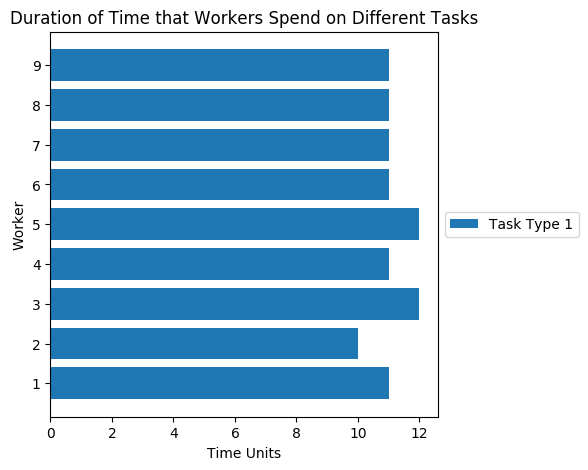

In [2]:
# This function plots a horizontal bar graph to help visualize task assignment/complete for each worker over time.
# This function accepts arguments for the number of workers, n_workers, the number of task types, n_task_types, and 
# a matrix where the rows represent workers and the columns represent the duration that worker worked on a 
# certain task type, task_dur.
function plot_task_dur(n_workers, n_task_types, task_dur)
    ind = 1:n_workers
    width = 0.35

    ax = Array{Any}(size(task_dur, 2))
    
    lft = zeros(n_workers)
    
    figure(figsize=[5, 5])
    for j=1:size(task_dur, 2)
        ax[j] = barh(ind, task_dur[:, j], left=lft, label="Task Type $j")
        lft = lft + task_dur[:, j]
    end
    
    ylabel("Worker")
    xlabel("Time Units")
    title("Duration of Time that Workers Spend on Different Tasks")
    legend(loc="center left", bbox_to_anchor=(1, 0.5))
    yticks(1:n_workers)
end

workSchedule = getvalue(x)

# task_dur is a matrix where the rows represent workers and columns represent the total time spent working
# on a particular task type
# task_dur = sum(schedule[:, i, :] for i=1:M)
task_dur = zeros(M)
for i=1:M
    task_dur[i] = sum(workSchedule[:, i, :])
end
plot_task_dur(M, 1, task_dur);


This model performs as expected.  If each worker completes every job at the same pace, the most efficient method of dividing the work is to have each worker be assigned the same number of tasks. The next step is to model the variety of skills each worker may have.

### 3.B Model 2: Variety Assignment

In [3]:
####################
# Variety Assingment
####################

# Task/Worker Parameters
###############################
N = rand(8:12,1, 5)  # 5 task types, with quotas ranging from 15 to 25
W = rand(1:10, 6, 5)  # 6 workers with task completion speeds ranging from 1 to 10

n = maximum(N) #max number of tasks for a category
v = size(N,2) # number of types of tasks

## Each row of W is a worker, and the column is the time required for the worker to complete that task
w = size(W,1) #number of workers

T = convert(Int64,maximum(W)*sum(N)) #upper bound on project completion

# Solver
###############################
using JuMP, Gurobi, PyPlot
m = Model(solver=GurobiSolver(OutputFlag=0))

@variable(m, x[1:n, 1:v, 1:w, 1:T], Bin) # true when a worker starts a task
@variable(m, z[1:n, 1:v, 1:w, 1:T], Bin) #true if a worker is working on a task (extends x with task length)

@variable(m, last)

#If a worker starts a task at time t, z if true until the tasks completes
for i=1:n
    for j=1:v
        for k=1:w
            for t=1:T
                if t < T-convert(Int64,W[k,j])
                    @constraint(m, [l=1:convert(Int64,W[k,j])], z[i,j,k,t+l-1] >= x[i,j,k,t])  
                else
                    @constraint(m, [l=0:T-t], z[i,j,k,t+l] >= x[i,j,k,t])  
                end
            end
        end
    end
end

#only one task in z can be worked simultaneously
@constraint(m, [k=1:w, t=1:T], sum(z[:,:,k,t]) <= 1)

#expression is used as an epigraph to find the end time of the last task
@expression(m, end_t[j=1:n, k=1:v, i=1:w, t=1:T], (z[j,k,i,t])*(t+W[i,k]))
@expression(m, start_t[j=1:n, k=1:v, i=1:w], sum((x[j,k,i,t])*(t) for t=1:T))

# at most one job per timestep per person
@constraint(m, [t=1:T, i=1:w], sum(x[:, :, i, t]) <= 1)

# each task is only worked on once and all tasks are completed
@constraint(m, [j=1:n, i=1:v], sum(x[j, i, :, :]) <= 1)
@constraint(m, [i=1:v], sum(x[:,i,:,:]) == N[i])

# min { max_j end_t[j] }
@constraint(m, [j=1:n, k=1:v, i=1:w, t=1:T], last >= end_t[j,k,i,t])


@objective(m, Min, last)
status = solve(m)
timer = getsolvetime(m)
println("The minimum completion time is: ", getobjectivevalue(m))

Academic license - for non-commercial use only
The minimum completion time is: 19.0


The solution to this model provides us with a worker schedule that is the optimal distribution of tasks according the speed that each worker completes each task.

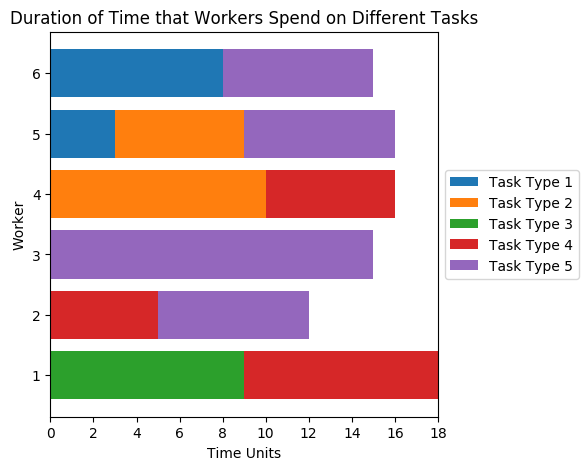

In [4]:
function plot_task_dur(n_workers, n_task_types, task_dur)
    ind = 1:n_workers
    width = 0.35

    ax = Array{Any}(size(task_dur, 2))
    
    lft = zeros(n_workers)
    
    figure(figsize=[5, 5])
    for j=1:size(task_dur, 2)
        ax[j] = barh(ind, task_dur[:, j], left=lft, label="Task Type $j")
        lft = lft + task_dur[:, j]
    end
    
    ylabel("Worker")
    xlabel("Time Units")
    title("Duration of Time that Workers Spend on Different Tasks")
    legend(loc="center left", bbox_to_anchor=(1, 0.5))
    yticks(1:n_workers)
end

schedule = getvalue(z)

# task_dur is a matrix where the rows represent workers and columns represent the total time spent working
# on a particular task type
task_dur = zeros(size(W, 1), v)

for i=1:w
    for j=1:v
        task_dur[i, j] = sum(schedule[:, j, i, :])
    end
end

plot_task_dur(w, n, task_dur);

Here, we can see that tasks tend to be distrubted across more than one worker, but from repeated runs we see than rarely do more than two workers work on a task.  The work is evenly distrubted across the abilitiy levels of of each worker according the quotas of each task type.  

### 3.C Model 3: Binary Task Bundles

This model no longer specifies the time when a worker begins a task and instead decides how many times each task type is assigned to a worker. Here we incorporate a worker learning model to estimate how a workers productivity on a task type increases overtime. To model the worker learning, we assume each additional task is can be completed according to a linearly decreasing function, with a cap on the maximum speed that can be achieved.  

In [5]:
using JuMP, Gurobi, PyPlot
# Parameters
############
quotaRange = 4:10
initialTaskLengthRange =  30:50
learningSpeedRange = 4:10
learningCurveMinLengthRange = 30:50
n_workers = 5
m_tasks = 8;

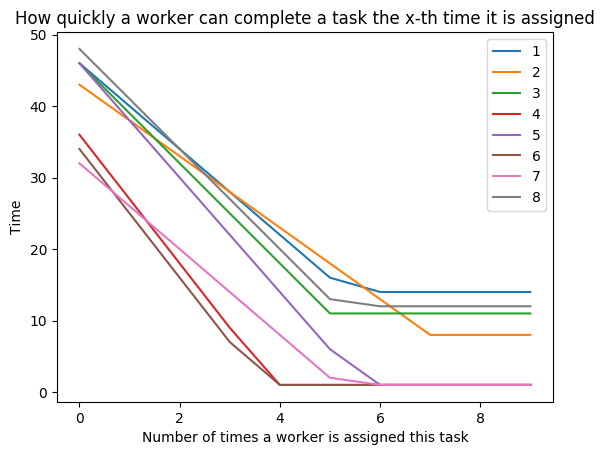

In [6]:
# Worker task learning
###########
quotas = rand(quotaRange,1,m_tasks) # 5 types of tasks with random quotas
horizon = maximum(quotas)
initial_task_lengths = rand(initialTaskLengthRange, m_tasks)
learning_speed = rand(learningSpeedRange, m_tasks)
min_task_lengths = max.(1, initial_task_lengths - rand(learningCurveMinLengthRange, m_tasks))

task_completion_speed = [(max.(min_task_lengths[j], initial_task_lengths[j]-T*learning_speed[j])) for j in 1:m_tasks, T in 0:horizon]
fig = figure(); plot(task_completion_speed')
legend(1:m_tasks); xlabel("Number of times a worker is assigned this task"); ylabel("Time")
title("How quickly a worker can complete a task the x-th time it is assigned");
fig[:canvas][:draw]() # Update the figure
gcf(); # Needed for IJulia to plot inline

From this, the total time to complete $x$ tasks is the summation from $1$ to $x$ for each task type.  We calculate this value to be used in the cost function of our model:

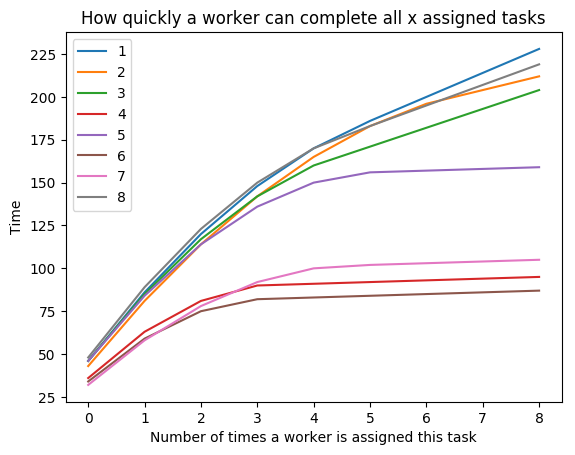

In [7]:
task_bundle_times = [sum(task_completion_speed[j,t] for t in 1:T) for j in 1:m_tasks, T in 1:horizon]
fig = figure(); plot(task_bundle_times')
legend(1:m_tasks); xlabel("Number of times a worker is assigned this task"); ylabel("Time")
title("How quickly a worker can complete all x assigned tasks");
fig[:canvas][:draw]() # Update the figure
gcf(); # Needed for IJulia to plot inline

This information is used to calculate how much time a worker will require to complete each task they have been assigned.  Our optimization model can use any input data that describes how long a worker will take to finish $x$ tasks and so is extremely flexible in regards to how worker productivity is modeled.  We can easily extend our model to include individual worker abilities, worker learning rates per task, decreasing returns above a certain work assignment, and more.

In [8]:
# Model Solving
###############################

m = Model(solver=GurobiSolver(OutputFlag=0))
@variable(m, work[1:n_workers, 1:m_tasks, 1:horizon], Bin)
@variable(m, slowest_worker >= 0)

@expression(m, work_on[j in 1:m_tasks], sum(work[i,j,t]*t for t in 1:horizon, i in 1:n_workers))

# we must meet quotas
@constraint(m, quota_constr[j in 1:m_tasks], work_on[j] >= quotas[j])

# worker speed
@expression(m, worker_speed[i in 1:n_workers],
    sum(sum(task_bundle_times[j, t] * work[i,j,t] for t in 1:horizon) for j in 1:m_tasks))

# Each worker works on either 1 task, 2 tasks, 3 etc.
for i in 1:n_workers, j in 1:m_tasks
    addSOS1(m, work[i,j,:])
end

# epigraph bound for slowest_worker
@constraint(m, worker_speed .<= slowest_worker)

# minimize the amount of time the slowest worker takes
@objective(m, Min, slowest_worker)

solve(m)
timer = getsolvetime(m)
println("The minimum completion time is: ", getobjectivevalue(m))


Academic license - for non-commercial use only
The minimum completion time is: 244.0


After we find the optimal division of labor between our workers, we can construct a schedule that shows how long each worker works each task type.

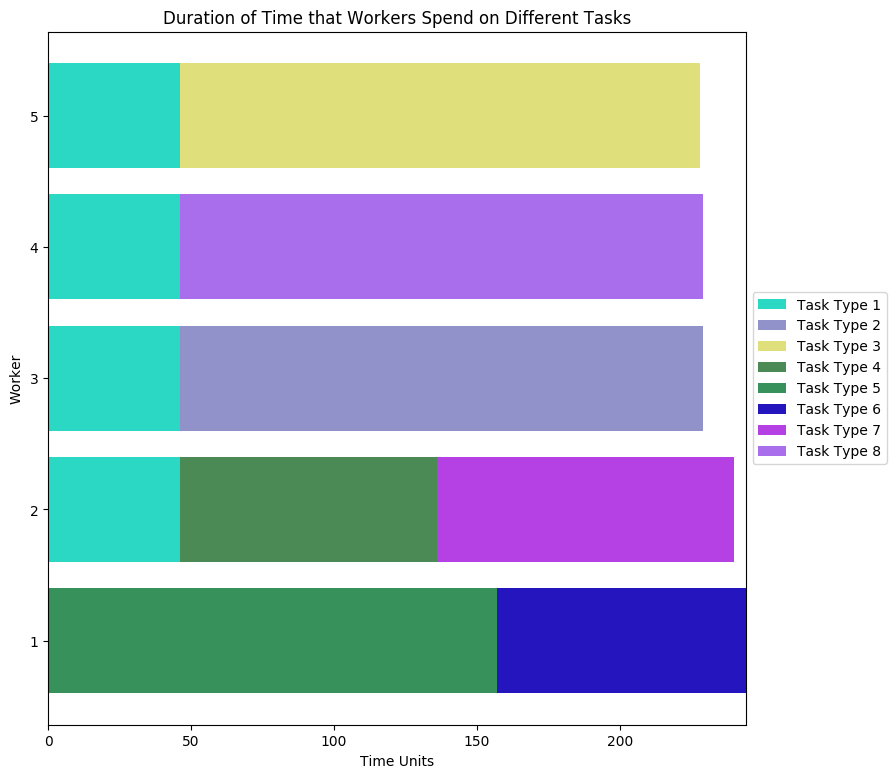

In [9]:
# Plotting worker schedule
##########################

# task_dur is a matrix where the rows represent workers and columns represent the total time spent working
# on a particular task type
α = getvalue(work)
L = round.(Int, sum(α[:,:,i]*i for i=1:horizon))
task_dur = zeros(n_workers, m_tasks)

for i=1:n_workers
    for j=1:m_tasks
        for k=1:L[i, j]
            task_dur[i, j] = task_dur[i, j] + task_completion_speed[j, k]
        end
    end
end

ind = 1:n_workers
width = 0.35

fig = figure(figsize=[9, 9])

colors = rand(m_tasks)
lft = zeros(n_workers)

for j=1:size(task_dur)[2]
    barh(ind, task_dur[:, j], left=lft, color=rand(3), label="Task Type $j")
    #barh(ind, task_dur[:, j], left=lft, label="Task Type $j")
    lft = lft + task_dur[:, j]
end

ylabel("Worker")
xlabel("Time Units")
title("Duration of Time that Workers Spend on Different Tasks")
legend(loc="center left", bbox_to_anchor=(1, 0.5))
fig[:canvas][:draw]() # Update the figure
gcf(); # Needed for IJulia to plot inline
;

The limitations of this model are that we would not be able to account for the effects of temporal density of task assignments on worker productivity in our worker learning model.  However, the considerable increase in solving speed ([Section 4.A](#4.A-Model-Solving-Speed)) allow us to capture much larger problem sets to analyze how much of an increase in project completion we can expect for large-scale projects.

## 4. Results and discussion ##
First we analyze the solving speed of each model, and show how they scale as different parameters increase.  We focus on the comparison between Model 2 - Variety Assignments and Model 3 - Binary Task Bundles to show the increased efficiency in solving a problem without discrete time.

Next we analyze the the results from Binary Task Bundles to answer questions about the how the different initial conditions of worker skills and required tasks affect the optimal worker task assignments.  

### 4.A Model Solving Speed ###

We tested the time required to solve our three models with various numbers of workers, tasks, and task types to estimate the scaling potential as the problem size increases. This resulted in interesting relations between the number of tasks and number of workers on the solver time.

For each model, we scaled the size of one of the input parameters to the problem and compared the time to solve each problem relative to the original one-times scaling problem.  Code to generate this data can be found in the [Appendix](#Appendix).

### 4.A.a Simple Assignment Speed ### 

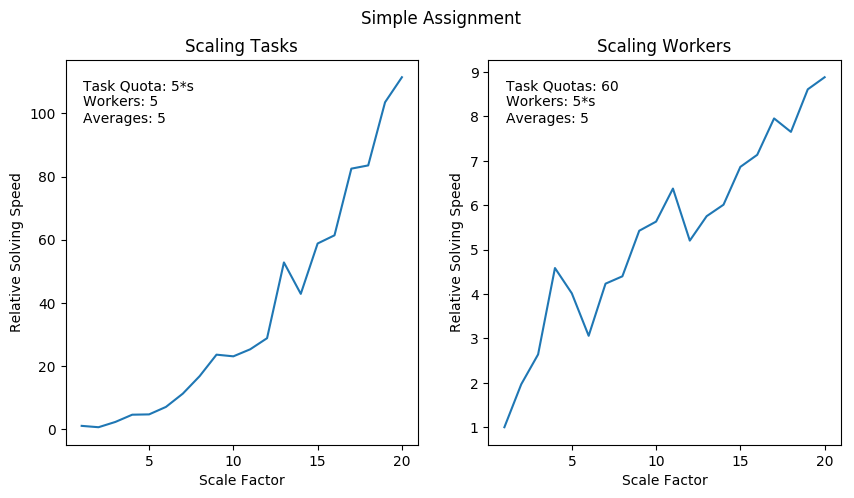

In [10]:
using PyPlot

### Simple Assignment Data ###
#Scaling Tasks
SM1 =[1.0, 0.57143, 2.24756, 4.53919, 4.63766, 7.00508, 11.2083, 16.7623, 23.5657, 23.0381, 25.2694, 28.7922, 52.7929, 42.8318, 58.7976, 61.3877, 82.5161, 83.5397, 103.553, 111.489]
#Scaling workers
SM2=[1.0, 1.96746, 2.64001, 4.58475, 4.01553, 3.05895, 4.23258, 4.39835, 5.4244, 5.63077, 6.37447, 5.20242, 5.75265, 6.01087, 6.86303, 7.13417, 7.9541, 7.65064, 8.60955, 8.88195]

n = 20 

fig = figure("pyplot_subplot_mixed",figsize=(10,5)) # Create a new blank figure
subplot(121); plot(1:n, SM1); 
title("Scaling Tasks"); xlabel("Scale Factor"); ylabel("Relative Solving Speed")
annotate("Task Quota: 5*s \nWorkers: 5 \nAverages: 5", 
           xy=[0.05;0.95], xycoords="axes fraction", ha="left",va="top")

subplot(122); plot(1:n, SM2); 
title("Scaling Workers"); xlabel("Scale Factor"); ylabel("Relative Solving Speed")
annotate("Task Quotas: 60 \nWorkers: 5*s \nAverages: 5", 
           xy=[0.05;0.95], xycoords="axes fraction", ha="left",va="top")

suptitle("Simple Assignment")
fig[:canvas][:draw]() # Update the figure
gcf(); # Needed for IJulia to plot inline

This problem scales very well for a mixed-integer program, and seems to be on the order of O(n) as both inputs scale.  A potentially interesting point in the second graph is when the scale factor is 10, we have the same number of workers and tasks, and so above this point, there may be several workers who are never assigned a task.  However, this seems to have no impact on the solving speed of this model.  

### 4.A.b Variety Assignment Speed ###

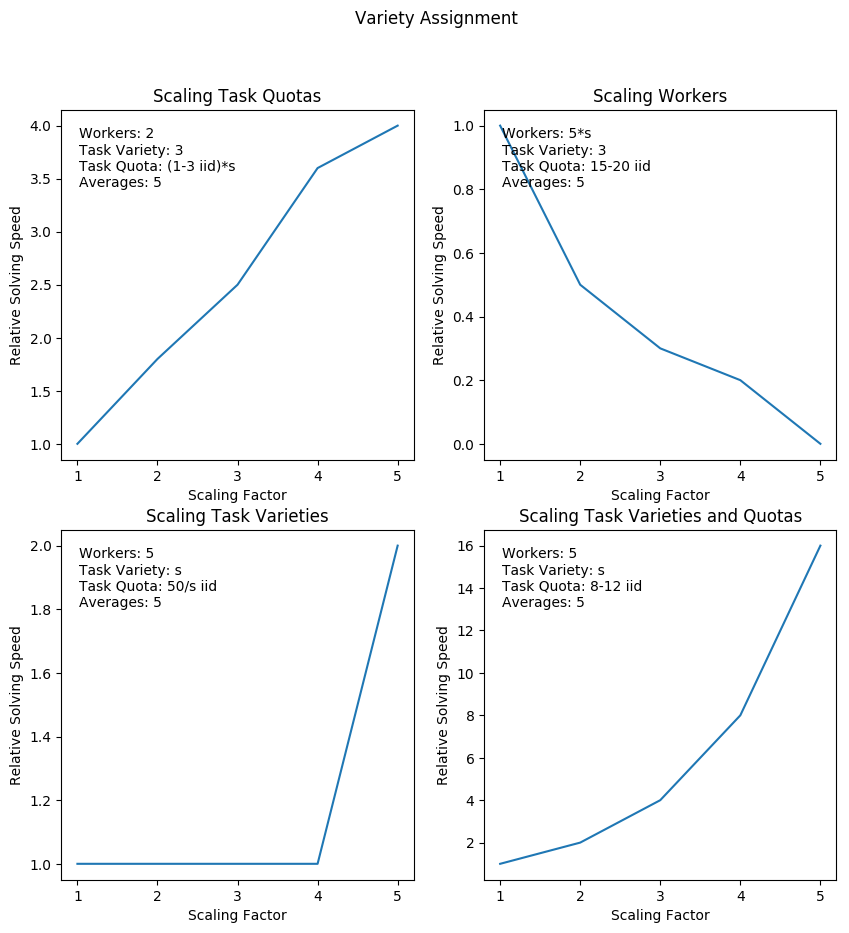

In [11]:
### Variety Assignment ###
# Scaling tasks
VA1=[1 1.8 2.5 3.6 4]
#Scaling of workers
VA2=[1 .5 .3 .2 0]
# Scaling Task Variety, constant # of tasks
VA3=[1 1 1 1 2 ]
#scaling Task variety and tasks
VA4=[1 2 4 8 16]

n=5

fig = figure("pyplot_subplot_mixed",figsize=(10,10)) # Create a new blank figure
subplot(221); plot(1:n, VA1');
title("Scaling Task Quotas"); xlabel("Scaling Factor"); ylabel("Relative Solving Speed")
annotate("Workers: 2 \nTask Variety: 3 \nTask Quota: (1-3 iid)*s \nAverages: 5", 
           xy=[0.05;0.95], xycoords="axes fraction", ha="left",va="top")

subplot(222); plot(1:n, VA2');
title("Scaling Workers"); xlabel("Scaling Factor"); ylabel("Relative Solving Speed")
annotate("Workers: 5*s \nTask Variety: 3 \nTask Quota: 15-20 iid \nAverages: 5", 
           xy=[0.05;0.95], xycoords="axes fraction", ha="left",va="top")

subplot(223); plot(1:n, VA3'); 
title("Scaling Task Varieties"); xlabel("Scaling Factor"); ylabel("Relative Solving Speed")
annotate("Workers: 5 \nTask Variety: s \nTask Quota: 50/s iid \nAverages: 5", 
           xy=[0.05;0.95], xycoords="axes fraction", ha="left",va="top")

subplot(224); plot(1:n, VA4'); 
title("Scaling Task Varieties and Quotas"); xlabel("Scaling Factor"); ylabel("Relative Solving Speed")
annotate("Workers: 5 \nTask Variety: s \nTask Quota: 8-12 iid \nAverages: 5", 
           xy=[0.05;0.95], xycoords="axes fraction", ha="left",va="top")

suptitle("Variety Assignment")
fig[:canvas][:draw]() # Update the figure
gcf(); # Needed for IJulia to plot inline




**What can we interpret from these plots?**

### 4.A.c Binary Task Bundles Speed ###

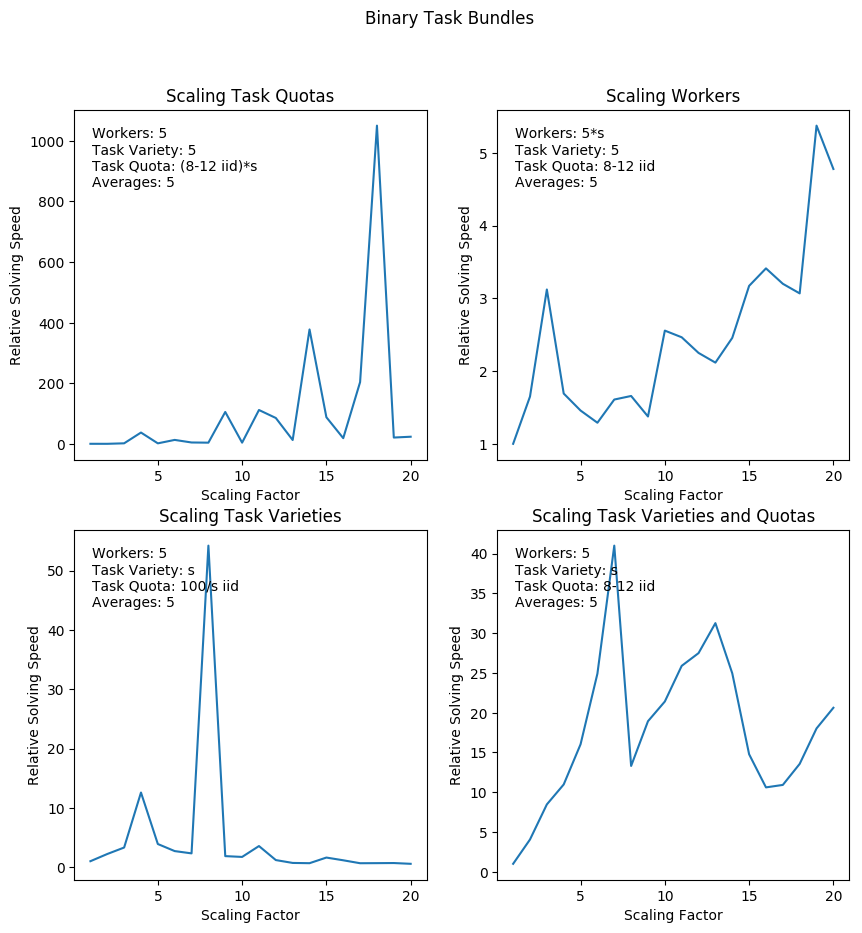

In [12]:
### Binary Task Bundles ###
# Scaling tasks
BTB1=[1.0, 0.944222, 2.5731, 38.0854, 2.48491, 13.8282, 5.31442, 4.72224, 105.985, 4.74393, 112.438, 86.0962, 13.4782, 378.049, 88.5545, 19.5509, 204.36, 1050.04, 21.6221, 24.308]
#Scaling of workers
BTB2=[1.0, 1.6499, 3.12206, 1.69142, 1.45761, 1.28982, 1.60874, 1.65788, 1.37557, 2.55686, 2.46518, 2.24998, 2.11663, 2.45685, 3.17194, 3.41251, 3.20084, 3.06863, 5.37571, 4.77939]
# Scaling Task Variety, constant # of tasks
BTB3=[1.0, 2.21394, 3.30483, 12.5813, 3.89896, 2.70547, 2.3188, 54.2228, 1.85634, 1.72128, 3.55493, 1.19017, 0.707801, 0.664048, 1.6138, 1.15357, 0.658361, 0.672043, 0.690194, 0.559427]
#scaling Task variety and tasks
BTB4=[1.0, 4.05839, 8.47072, 10.9791, 16.0322, 24.9183, 41.0167, 13.3069, 18.9344, 21.4122, 25.8966, 27.4978, 31.2693, 24.9586, 14.7793, 10.6125, 10.9213, 13.5665, 18.0256, 20.6252]

n=20

fig = figure("pyplot_subplot_mixed",figsize=(10,10)) # Create a new blank figure
subplot(221); plot(1:n, BTB1)
title("Scaling Task Quotas"); xlabel("Scaling Factor"); ylabel("Relative Solving Speed")
annotate("Workers: 5 \nTask Variety: 5 \nTask Quota: (8-12 iid)*s \nAverages: 5", 
           xy=[0.05;0.95], xycoords="axes fraction", ha="left",va="top")

subplot(222); plot(1:n, BTB2)
title("Scaling Workers"); xlabel("Scaling Factor"); ylabel("Relative Solving Speed")
annotate("Workers: 5*s \nTask Variety: 5 \nTask Quota: 8-12 iid \nAverages: 5", 
           xy=[0.05;0.95], xycoords="axes fraction", ha="left",va="top")

subplot(223); plot(1:n, BTB3)
title("Scaling Task Varieties"); xlabel("Scaling Factor"); ylabel("Relative Solving Speed")
annotate("Workers: 5 \nTask Variety: s \nTask Quota: 100/s iid \nAverages: 5", 
           xy=[0.05;0.95], xycoords="axes fraction", ha="left",va="top")

subplot(224); plot(1:n, BTB4)
title("Scaling Task Varieties and Quotas"); xlabel("Scaling Factor"); ylabel("Relative Solving Speed")
annotate("Workers: 5 \nTask Variety: s \nTask Quota: 8-12 iid \nAverages: 5", 
           xy=[0.05;0.95], xycoords="axes fraction", ha="left",va="top")

suptitle("Binary Task Bundles")
fig[:canvas][:draw]() # Update the figure
gcf(); # Needed for IJulia to plot inline

Again, we scaled the input variable sizes to our optimization problem to find how the problem scaled across different input dimensions.  Here, the curves are not smooth, implying that the problem does not scale cleanly as the variable size scales and instead is highly dependent on the input values.  This is evident in repeated runs of this averaging as the on each run, peaks in the scaling are evident and are not consistently in the same locations. However, even in the worst case secenarios changing each variable size was on the order of O(n).  

The exception to this is in the graph of Scaling Task Quotas. This graph has very extreme variations in the scaling, where at 18x scaling it seems to be O(n^2) but at 19x scaling, it becomes less than linear.  

Overall, this model is able to scale to extremely large problems and should still be able to solve them in a reasonable time.  

### 4.1.d Binary Task Bundles vs. Variety Assignment Speed ###

We are especially interested in comparing the solution speed of Binary Task Bundles and Variety Assignment to see if our relaxation of a solution is significantly faster.  The following plots contain the absolute solution time, rather than the speed relative to one-times scaling.

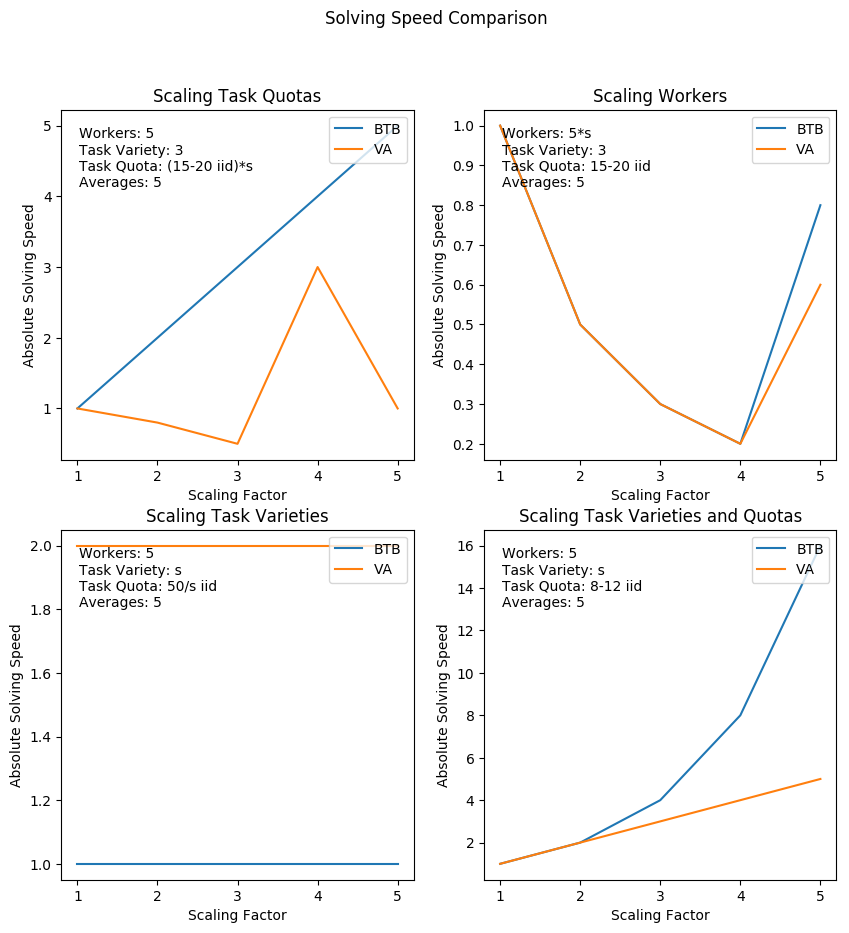

In [13]:
### Binary Task Bundles ###
# Scaling tasks
BTB1=[1 2 3 4 5]
#Scaling of workers
BTB2=[1 .5 .3 .2 .8]
# Scaling Task Variety, constant # of tasks
BTB3=[1 1 1 1 1]
#scaling Task variety and tasks
BTB4=[1 2 4 8 16]

### Variety Assignment ###
# Scaling tasks
VA1=[1 0.8 0.5 3 1]
#Scaling of workers
VA2=[1 .5 .3 .2 .6]
# Scaling Task Variety, constant # of tasks
VA3=[2 2 2 2 2]
#scaling Task variety and tasks
VA4=[1 2 3 4 5]

n = 5

fig = figure("pyplot_subplot_mixed",figsize=(10,10)) # Create a new blank figure
subplot(221); p1 = plot(1:n,BTB1', label="BTB"); p1=plot(1:n, VA1', label="VA"); legend(loc="upper right")
title("Scaling Task Quotas"); xlabel("Scaling Factor"); ylabel("Absolute Solving Speed")
annotate("Workers: 5 \nTask Variety: 3 \nTask Quota: (15-20 iid)*s \nAverages: 5", 
           xy=[0.05;0.95], xycoords="axes fraction", ha="left",va="top")

subplot(222); p2=plot(1:n, BTB2', label="BTB"); p2=plot(1:n, VA2', label="VA"); legend(loc="upper right")
title("Scaling Workers"); xlabel("Scaling Factor"); ylabel("Absolute Solving Speed")
annotate("Workers: 5*s \nTask Variety: 3 \nTask Quota: 15-20 iid \nAverages: 5", 
           xy=[0.05;0.95], xycoords="axes fraction", ha="left",va="top")

subplot(223); p3=plot(1:n, BTB3', label="BTB"); p3=plot(1:n, VA3', label="VA"); legend(loc="upper right")
title("Scaling Task Varieties"); xlabel("Scaling Factor"); ylabel("Absolute Solving Speed")
annotate("Workers: 5 \nTask Variety: s \nTask Quota: 50/s iid \nAverages: 5", 
           xy=[0.05;0.95], xycoords="axes fraction", ha="left",va="top")

subplot(224); p4=plot(1:n, BTB4', label="BTB"); p4=plot(1:n, VA4', label="VA"); legend(loc="upper right")
title("Scaling Task Varieties and Quotas"); xlabel("Scaling Factor"); ylabel("Absolute Solving Speed")
annotate("Workers: 5 \nTask Variety: s \nTask Quota: 8-12 iid \nAverages: 5", 
           xy=[0.05;0.95], xycoords="axes fraction", ha="left",va="top")

suptitle("Solving Speed Comparison")
fig[:canvas][:draw]() # Update the figure
gcf(); # Needed for IJulia to plot inline

** How do the solving speeds compare?**

### 4.B Data Interpretation###
**Interpret our 3rd model with different starting conditions of workers/tasks here**



### 4.C Anything to discuss? ###

## 5. Conclusion ##

*Summarize your findings and your results, and talk about at least one possible future direction; something that might be interesting to pursue as a follow-up to your project.*

Follow up: 

Accurate learning models from literature
Modeling decreases in task completion speed in addition to speed up

Does the time upper bound cause significant slowdown in model 2?  If so, better up bounding?

Model a series of consecutive task bundles, such as how many of all required subtasks are required to build a boat can be accomplished each month.  How does being able to anticipate the skills needed months in advance help plan for training workers in advance of struggling to meet time limits? (adaption of overtime work from lecture early in the semester...more productive workers can lead to less overtime spending)

Using this model in a subset of of project timeline:  We are constructing a building, and each step has several required subtasks.  Our model can solve for the speed of completing all subtasks at each step, how does this impact an entire construction timeline for a building?

## Appendix ##

### Model Solving Speed Code

**WARNING** The following code blocks take approximately 48 hours to run!

In [2]:
using JuMP, Gurobi, PyPlot, ProgressMeter

env = Gurobi.Env()

function simpleModel(N,M)
    T = N #upper bound on project completion

    #m = Model(solver=CbcSolver)
    m = Model(solver=GurobiSolver(env, OutputFlag=0))

    @variable(m, x[1:N, 1:M, 1:T], Bin)
    @variable(m, last)

    # due to the following two constraints, this just selects the time
    # when x[j, i, t] = 1, since x[j, :, :] has only one nonzero elemnt
    @expression(m, start_t[j=1:N], sum(x[j, i, t] * t for i=1:M for t=1:T))

    # at most one job per timestep per person
    @constraint(m, [t=1:T, i=1:M], sum(x[:, i, t]) <= 1)

    # each task is only worked on once
    @constraint(m, [j=1:N], sum(x[j, :, :]) == 1)

    # min { max_j end_t[j] }
    @constraint(m, [j=1:N], last >= start_t[j] + 1)

    @objective(m, Min, last)

    solve(m)
    timer = getsolvetime(m)
    return timer
end
                
function discreteTimeModel(N,W)
    # Task/Worker Parameters
    ###############################

    ## We require 5 of task_1, 1 of task_2, etc.
    n = maximum(N) #max number of tasks for a category
    v = size(N,1) # number of types of tasks

    ## Each row of W is a worker, and the column is the time required for the worker to complete that task
    w = size(W,1) #number of workers

    T = convert(Int64,maximum(W)*sum(N)) #upper bound on project completion

    # Solver
    ###############################
    m = Model(solver=GurobiSolver(env, OutputFlag=0))

    @variable(m, x[1:n, 1:v, 1:w, 1:T], Bin) # true when a worker starts a task
    @variable(m, z[1:n, 1:v, 1:w, 1:T], Bin) #true if a worker is working on a task (extends x with task length)

    @variable(m, last)

    #If a worker starts a task at time t, z if true until the tasks completes
    for i=1:n
        for j=1:v
            for k=1:w
                for t=1:T
                    if t < T-convert(Int64,W[k,j])
                        @constraint(m, [l=1:convert(Int64,W[k,j])], z[i,j,k,t+l-1] >= x[i,j,k,t])  
                    else
                        @constraint(m, [l=0:T-t], z[i,j,k,t+l] >= x[i,j,k,t])  
                    end
                end
            end
        end
    end

    #only one task in z can be worked simultaneously
    @constraint(m, [k=1:w, t=1:T], sum(z[:,:,k,t]) <= 1)

    #expression is used as an epigraph to find the end time of the last task
    @expression(m, end_t[j=1:n, k=1:v, i=1:w, t=1:T], (z[j,k,i,t])*(t+W[i,k]))
    @expression(m, start_t[j=1:n, k=1:v, i=1:w], sum((x[j,k,i,t])*(t) for t=1:T))

    # at most one job per timestep per person
    @constraint(m, [t=1:T, i=1:w], sum(x[:, :, i, t]) <= 1)

    # each task is only worked on once and all tasks are completed
    @constraint(m, [j=1:n, i=1:v], sum(x[j, i, :, :]) <= 1)
    @constraint(m, [i=1:v], sum(x[:,i,:,:]) == N[i])

    # min { max_j end_t[j] }
    @constraint(m, [j=1:n, k=1:v, i=1:w, t=1:T], last >= end_t[j,k,i,t])

    @objective(m, Min, last)    
    solve(m)
    timer = getsolvetime(m)
    return timer
end
                
function binaryTaskBundles(quotas, n_workers)
  
    # Task/Worker Parameters
    ###############################
    m_tasks = length(quotas)
    horizon = maximum(quotas)

    initial_task_lengths = rand(1:10, m_tasks)
    min_task_lengths = max.(1, initial_task_lengths - rand(1:10, m_tasks))
    task_bundle_times = [sum(max(min_task_lengths[j], initial_task_lengths[j]-t) for t in 1:T) for j in 1:m_tasks, T in 1:horizon]

    ###############################

    m = Model(solver=GurobiSolver(env, OutputFlag=0))
    @variable(m, work[1:n_workers, 1:m_tasks, 1:horizon], Bin)
    @variable(m, slowest_worker >= 0)

    @expression(m, work_on[j in 1:m_tasks], sum(work[i,j,t]*t for t in 1:horizon, i in 1:n_workers))

    # we must meet quotas
    @constraint(m, quota_constr[j in 1:m_tasks], work_on[j] >= quotas[j])

    # worker speed
    @expression(m, worker_speed[i in 1:n_workers],
        sum(sum(task_bundle_times[j, t] * work[i,j,t] for t in 1:horizon) for j in 1:m_tasks))

    for i in 1:n_workers, j in 1:m_tasks
        addSOS1(m, work[i,j,:])
    end

    # ∞-norm epigraph bounds for slowest_worker
    @constraints(m, begin
        worker_speed .<= slowest_worker
        -slowest_worker .<= worker_speed
    end)

    # minimize the amount of time the slowest worker takes
    @objective(m, Min, slowest_worker)
    
    solve(m)
    timer = getsolvetime(m)
    return timer
end

## have consistent scale factor and averages
scaleFactor = 20
averages = 5

5

Academic license - for non-commercial use only


#### Model 1 - Tasks

5 workers, number of tasks ranges from 5 to 100.

Academic license - for non-commercial use only


[1]: 100%|██████████████████████████████████████████████| Time: 0:00:09
[2]: 100%|██████████████████████████████████████████████| Time: 0:00:09
[3]: 100%|██████████████████████████████████████████████| Time: 0:00:10
[4]: 100%|██████████████████████████████████████████████| Time: 0:00:09
[5]: 100%|██████████████████████████████████████████████| Time: 0:00:09


Relative speed: 

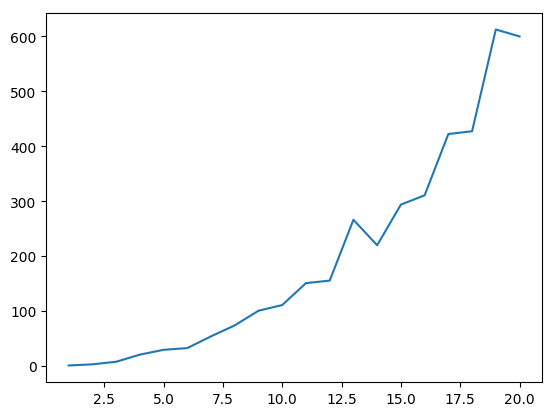

[1.0, 3.09693, 7.78217, 20.7263, 29.5446, 32.6379, 54.031, 74.0044, 100.637, 111.023, 150.907, 155.476, 266.185, 219.875, 293.831, 310.689, 422.281, 427.334, 612.598, 599.941]
Timer to solve: [0.00210152, 0.00650826, 0.0163544, 0.0435566, 0.0620884, 0.068589, 0.113547, 0.155521, 0.211489, 0.233316, 0.317133, 0.326735, 0.559392, 0.462072, 0.617491, 0.652917, 0.88743, 0.898049, 1.28739, 1.26079]


In [15]:
timer = zeros(scaleFactor)

N = 5; W= 5 # task, worker, time inital values
for p=1:averages
    @showprogress "[$p]: " for u=1:scaleFactor
        timer[u] = timer[u] + simpleModel(N*u,W)
    end
end

timer= timer./averages
speed = timer./timer[1]

plot(1:scaleFactor,speed)
println("Relative speed: ", speed)
println("Timer to solve: ", timer)

#### Model 1 - Workers

60 tasks; workers vary from 5 to 100.

[1]: 100%|██████████████████████████████████████████████| Time: 0:00:47
[2]: 100%|██████████████████████████████████████████████| Time: 0:00:44
[3]: 100%|██████████████████████████████████████████████| Time: 0:00:44
[4]: 100%|██████████████████████████████████████████████| Time: 0:00:44
[5]: 100%|██████████████████████████████████████████████| Time: 0:00:46


Relative speed: 

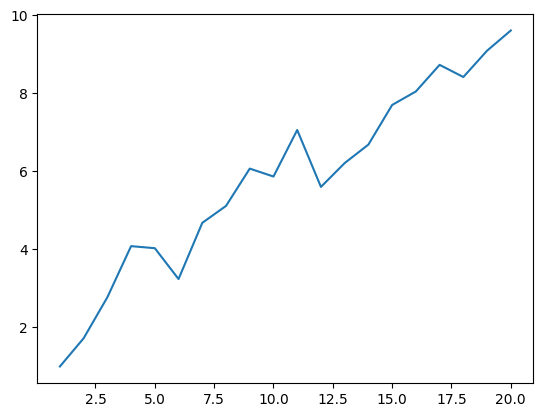

[1.0, 1.72282, 2.77417, 4.0856, 4.03265, 3.24188, 4.68263, 5.11684, 6.07342, 5.87066, 7.06376, 5.60419, 6.21554, 6.68937, 7.70519, 8.05168, 8.73347, 8.42148, 9.09657, 9.6151]
Timer to solve: [0.328386, 0.565751, 0.910998, 1.34165, 1.32427, 1.06459, 1.53771, 1.6803, 1.99442, 1.92784, 2.31964, 1.84034, 2.04109, 2.19669, 2.53027, 2.64405, 2.86794, 2.76549, 2.98718, 3.15746]


In [3]:
timer = zeros(scaleFactor)

N = 60; W= 5 # task, worker, time inital valuesN = 5; W= 5 # task, worker, time inital values
for p=1:averages
    @showprogress "[$p]: " for u=1:scaleFactor
        timer[u] = timer[u] + simpleModel(N,W*u,)
    end
end

timer= timer./averages
speed = timer./timer[1]

plot(1:scaleFactor,speed)
println("Relative speed: ", speed)
println("Timer to solve: ", timer)

#### Model 2 - Tasks 

Number of workers and task types held constant; total number of tasks scales.

In [ ]:
timer = zeros(scaleFactor)

for p=1:averages
    # task, worker value
    N = rand(8:12,1,5)
    W = rand(1:10,5,5)
    @showprogress "[$p]: " for u=1:scaleFactor
        timer[u] = timer[u] + discreteTimeModel(N*u,W)
    end
end

timer= timer./averages
speed = timer./timer[1]

plot(1:scaleFactor,speed)
println("Relative speed: ", speed)
println("Timer to solve: ", timer)

#### Model 2 - Workers

Number of tasks and types of tasks held constant; number of workers scales.

In [ ]:
timer = zeros(scaleFactor)

for p=1:averages
    # task, worker values
    N = rand(8:12,1,5)
    W = rand(1:10, 5,5)
    @showprogress "[$p]: " for u=1:scaleFactor
        W = [W; rand(1:10, 5,5)]
        timer[u] = timer[u] + discreteTimeModel(N,W)
    end
end

timer= timer./averages
speed = timer./timer[1]

plot(1:scaleFactor,speed)
println("Relative speed: ", speed)
println("Timer to solve: ", timer)

#### Model 2 - Task Variety
Number of workers and tasks held constant; variety of task types scales.

In [ ]:
timer = zeros(scaleFactor)


for p=1:averages
    # task, worker values
    N = 100
    W = rand(1:10,5,1)
    timer[1] = timer[1] + discreteTimeModel(N,W)
    @showprogress "[$p]: " for u=2:scaleFactor
        N = round.(Int, 100/u * ones(u))
        W = [W rand(1:10, 5,1)]
        timer[u] = timer[u] + discreteTimeModel(N,W)
    end
end

timer= timer./averages
speed = timer./timer[1]

plot(1:scaleFactor,speed)
println("Relative speed: ", speed)
println("Timer to solve: ", timer)

#### Model 2 - Task Variety, tasks number scales accordingly.
Number of workers constant; variety of task types scales, and each task is done the same number of times.

In [ ]:
timer = zeros(scaleFactor)

for p=1:averages
    # task, worker values
    N = rand(8:12,1,1)
    W = rand(1:10,5,1)
    time[1] = time[1] + discreteTimeModel(N,W)
    @showprogress "[$p]: " for u=2:scaleFactor
        N = [N rand(8:12,1,1)]
        W = [W rand(1:10, 5,1)]
        timer[u] = timer[u] + discreteTimeModel(N,W)
    end
end

timer= timer./averages
speed = timer./timer[1]

plot(1:scaleFactor,speed)
println("Relative speed: ", speed)
println("Timer to solve: ", timer)

#### Binary Task Bundles - Workers
n_tasks, quotas constant; n_workers is scaled.

[1]: 100%|██████████████████████████████████████████████| Time: 0:00:01
[2]: 100%|██████████████████████████████████████████████| Time: 0:00:02
[3]: 100%|██████████████████████████████████████████████| Time: 0:00:02
[4]: 100%|██████████████████████████████████████████████| Time: 0:00:02
[5]:  95%|████████████████████████████████████████████  |  ETA: 0:00:00

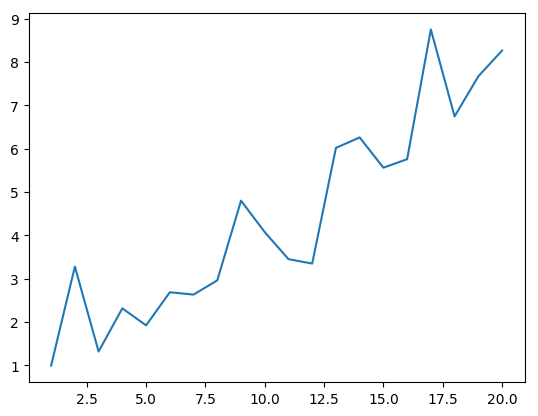

Relative speed: [1.0, 3.28005, 1.32265, 2.31771, 1.92508, 2.68866, 2.63472, 2.96296, 4.80099, 4.07607, 3.45218, 3.3502, 6.01776, 6.25936, 5.56142, 5.75758, 8.7491, 6.74437, 7.66818, 8.26274]
Timer to solve: [0.0186203, 0.0610756, 0.0246281, 0.0431564, 0.0358456, 0.0500637, 0.0490593, 0.0551712, 0.0893959, 0.0758976, 0.0642807, 0.0623817, 0.112053, 0.116551, 0.103555, 0.107208, 0.162911, 0.125582, 0.142784, 0.153855]


[5]: 100%|██████████████████████████████████████████████| Time: 0:00:02


In [16]:
timer = zeros(scaleFactor)

for p=1:averages
    # task, worker values
    N = rand(8:12,1,5)
    @showprogress "[$p]: " for u=1:scaleFactor
        W = 5*u
        timer[u] = timer[u] + binaryTaskBundles(N,W)
    end
end

timer= timer./averages
speed = timer./timer[1]

plot(1:scaleFactor,speed)
println("Relative speed: ", speed)
println("Timer to solve: ", timer)

#### Binary Task Bundles - Tasks
Number of workers and number of task types is constant; number of tasks scales.

In [ ]:
timer = zeros(scaleFactor)

for p=1:averages
    # task, worker values
    N = rand(8:12,1,5)
    W = 5
    timer[1] = timer[1] + binaryTaskBundles(N,W)
    @showprogress "[$p]: " for u=1:scaleFactor
        timer[u] = timer[u] + binaryTaskBundles(N*u,W)
    end
end

timer= timer./averages
speed = timer./timer[1]

plot(1:scaleFactor,speed)
println("Relative speed: ", speed)
println("Timer to solve: ", timer)

[1]:  75%|██████████████████████████████████            |  ETA: 0:00:03

#### Binary Task Bundles - Task Type
Number of workers and total tasks are constant; number of task types scales.

In [ ]:
timer = zeros(scaleFactor)

for p=1:averages
    # task, worker values
    N = 100
    W = 5
    timer[1] = timer[1] + binaryTaskBundles(N,W)
    @showprogress "[$p]: " for u=2:scaleFactor
        N = round.(Int, 100/u * ones(u))
        timer[u] = timer[u] + binaryTaskBundles(N,W)
    end
end

timer= timer./averages
speed = timer./timer[1]

plot(1:scaleFactor,speed)
println("Relative speed: ", speed)
println("Timer to solve: ", timer)

#### Binary Task Bundles - Tasks and Variety
Number of workers held constant; number of tasks scales, and total quota scales.

In [ ]:
timer = zeros(scaleFactor)

for p=1:averages
    # task, worker values
    N = rand(8:12,1,1)
    W = 5
    timer[1] = timer[1] + binaryTaskBundles(N,W)
    @showprogress "[$p]: " for u=2:scaleFactor
        N = [N rand(8:12,1,1)]
        timer[u] = timer[u] + binaryTaskBundles(N,W)
    end
end

timer= timer./averages
speed = timer./timer[1]

plot(1:scaleFactor,speed)
println("Relative speed: ", speed)
println("Timer to solve: ", timer)